# Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

/Users/luowx0905/opt/anaconda3/envs/ML_m1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Datasets

In [19]:
general = pd.read_csv("../datasets/general.csv")
room = pd.read_csv("../datasets/room.csv")
categorical = pd.read_csv("../datasets/categorical.csv")
labels = pd.read_csv("../datasets/label.csv")

## Merge Features

In [20]:
input_features = pd.concat([general, room, categorical], axis=1)
input_features.head()

,Postcode,Sale or Let,Price Qualifier,DESC Council Tax Band,RTD3316_condition1 - Condition Description,# of Enquiry or viewings,# of Apps/Offers,bedroom number,kitchen number,living number,...,Double Glazing,Eco-Friendly,Electric,Gas,Gas Central,Night Storage,Oil,Solar,Solar Water,Under Floor
0,1595,Sale,4,1,0,32,12,2,1,1,...,1,0,1,0,0,1,0,0,0,0
1,389,Sale,2,3,0,14,4,3,1,0,...,1,0,0,0,1,0,0,0,0,0
2,2185,Sale,2,4,0,10,2,3,1,1,...,1,0,0,0,1,0,0,0,0,1
3,196,Sale,7,1,0,9,1,3,1,1,...,0,0,0,0,1,0,0,0,0,0
4,998,Sale,6,1,0,1,2,3,1,0,...,0,0,0,0,1,0,0,0,0,0


## Split Sale and Rental

In [21]:
sale_features = input_features[input_features["Sale or Let"] == "Sale"]
sale_features = sale_features.loc[:, ~sale_features.columns.isin(["Sale or Let"])]
sale_labels = labels.iloc[sale_features.index]

rental_features = input_features[input_features["Sale or Let"] == "Rental"]
rental_features = rental_features.loc[:, ~rental_features.columns.isin(["Sale or Let"])]
rental_labels = labels.iloc[rental_features.index]

# Create Class for Collecting data

In [22]:
class PropertyDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        completed = torch.tensor(labels[0]).float().to(device)
        price = torch.tensor(labels[1]).float().to(device)

        return features, completed, price

    def __len__(self):
        return len(self.features)

In [23]:
temp = PropertyDataset(sale_features, sale_labels)

# Build the model

In [24]:
in_features = len(temp[0][0])

In [87]:
class ProbabilityAndPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.probability = nn.Sequential(nn.Linear(128, 1),
                                         nn.Sigmoid())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        probability = self.probability(x)
        price = self.price(x)
        return probability, price

In [26]:
model = ProbabilityAndPrice(in_features)

probability_loss = nn.BCELoss()
price_loss = nn.MSELoss()
loss_fn = probability_loss, price_loss

In [27]:
torchinfo.summary(model, input_size=(16, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
ProbabilityAndPrice                      [16, 1]                   --
├─Sequential: 1-1                        [16, 128]                 --
│    └─Linear: 2-1                       [16, 128]                 6,656
│    └─ReLU: 2-2                         [16, 128]                 --
│    └─Linear: 2-3                       [16, 128]                 16,512
│    └─ReLU: 2-4                         [16, 128]                 --
│    └─Linear: 2-5                       [16, 256]                 33,024
│    └─ReLU: 2-6                         [16, 256]                 --
│    └─Linear: 2-7                       [16, 128]                 32,896
│    └─ReLU: 2-8                         [16, 128]                 --
├─Sequential: 1-2                        [16, 1]                   --
│    └─Linear: 2-9                       [16, 1]                   129
│    └─Sigmoid: 2-10                     [16, 1]                   --

# Define train and validate loops

In [51]:
def train_batch(data, model, loss_fn, optimizer):
    model.train()

    feature, completed, price = data
    pred_pro, pred_price = model(feature)
    pred_pro = torch.where(pred_pro > 0.5, 1.0, 0.0)

    pro_loss_fn, price_loss_fn = loss_fn

    pro_loss = pro_loss_fn(pred_pro.squeeze(), completed)
    price_loss = price_loss_fn(pred_price.squeeze(), price)
    loss = pro_loss + price_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate_batch(data, model, loss_fn):
    model.eval()

    feature, completed, price = data
    pred_pro, pred_price = model(feature)
    pred_pro = torch.where(pred_pro > 0.5, 1.0, 0.0)

    pro_loss_fn, price_loss_fn = loss_fn

    pro_loss = pro_loss_fn(pred_pro.squeeze(), completed)
    price_loss = price_loss_fn(pred_price.squeeze(), price)
    loss = pro_loss + price_loss
    return loss.item()

# Data Standardization

In [45]:
scaler = StandardScaler()

scaler.fit(sale_features)
scaled_sale_feature = sale_features.copy()
scaled_sale_feature[:] = scaler.fit_transform(scaled_sale_feature)

scaler.fit(rental_features)
scaled_rental_feature = rental_features.copy()
scaled_rental_feature[:] = scaler.fit_transform(scaled_rental_feature)

# Train and test the model for sale data
## Prepare data

In [52]:
x_train, x_test, y_train, y_test = train_test_split(scaled_sale_feature, sale_labels, random_state=1, test_size=0.1)

## Cross validation

-------------This is fold 0----------------
EPOCH: 100.000	val_loss: 5800660480.000	(68.27s - -68.27s remaining))

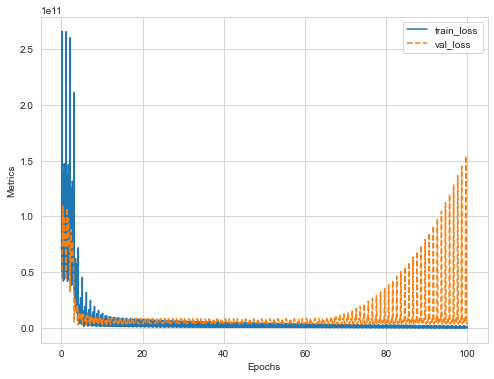

-------------This is fold 1----------------
EPOCH: 100.000	val_loss: 7202700288.000	(67.89s - -67.21s remaining))

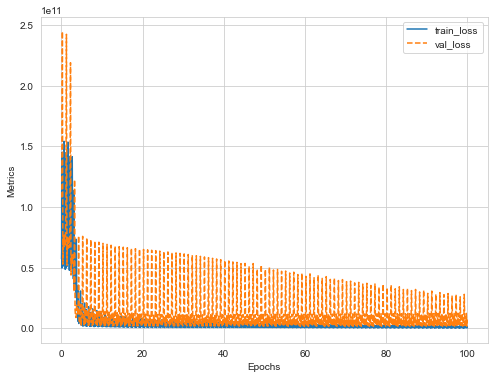

-------------This is fold 2----------------
EPOCH: 100.000	val_loss: 3234739200.000	(68.76s - -67.38s remaining))

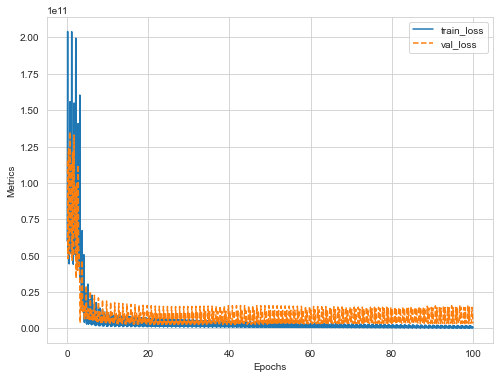

-------------This is fold 3----------------
EPOCH: 100.000	val_loss: 7300168192.000	(67.52s - -65.49s remaining))

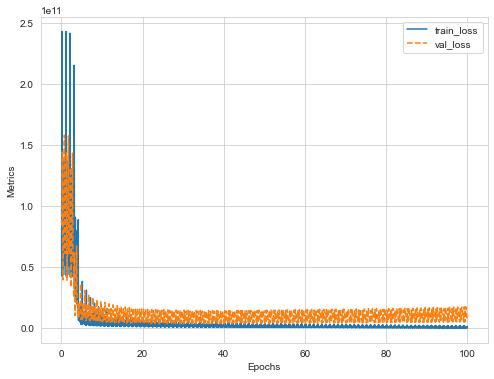

-------------This is fold 4----------------
EPOCH: 100.000	val_loss: 86417195008.000	(68.27s - -65.54s remaining)g)

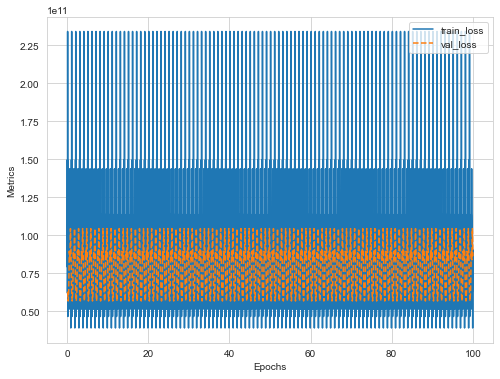

In [88]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 100

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("-------------This is fold {}----------------".format(fold))

    train_data = PropertyDataset(train_feature, train_label)
    val_data = PropertyDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True)

    log = Report(fold)
    model = ProbabilityAndPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        N = len(train_loader)
        for i, data in enumerate(train_loader):
            loss = train_batch(data, model, loss_fn, optimizer)
            log.record(epoch + (i + 1) / N, train_loss=loss, end='\r')

        N = len(val_loader)
        for i, data in enumerate(val_loader):
            loss = validate_batch(data, model, loss_fn)
            log.record(epoch + (i + 1) / N, val_loss=loss, end='\r')

        #log.report_avgs(epoch + 1)

    torch.save(model, "models/sale_fold_{}.pth".format(fold))
    log.plot()

## Test sale model

In [89]:
filename = "models/sale_fold_5_2.pth"

model = torch.load(filename)
model.cpu()
model.eval()
completed, prices = [], []
for i in range(len(x_test)):
    feature = torch.tensor(x_test.iloc[i]).float()
    pred_com, pred_price = model(feature)
    completed.append(pred_com.detach().item())
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"pred_completed": completed, "pred_price": prices})

In [103]:
pred = pd.DataFrame({"pred_completed": completed, "pred_price": prices})
pred = pred.rename(index={i: j for i, j in zip(pred.index, y_test.index)})
compare = pd.concat([y_test, pred], axis=1)

In [104]:
compare

,Completed,Price,pred_completed,pred_price
253,1,675000.0,1.0,600810.812500
661,0,80000.0,1.0,136130.078125
836,0,90000.0,1.0,53198.960938
130,0,295000.0,1.0,253552.390625
518,0,105000.0,1.0,105753.484375
...,...,...,...,...
777,1,270000.0,1.0,297239.968750
174,0,115000.0,1.0,124108.070312
914,1,600000.0,1.0,528918.312500
239,1,400000.0,1.0,376152.968750


In [105]:
error = []
for i in range(len(compare)):
    truth = compare.Price.iloc[i]
    pred = compare.pred_price.iloc[i]

    error.append(abs(truth - pred) / truth)
error = pd.DataFrame({"price error": ["{:.2f}%".format(i * 100) for i in error]})
error = error.rename(index={i: j for i, j in zip(error.index, compare.index)})

compare = pd.concat([compare, error], axis=1)

In [106]:
compare

,Completed,Price,pred_completed,pred_price,price error
253,1,675000.0,1.0,600810.812500,10.99%
661,0,80000.0,1.0,136130.078125,70.16%
836,0,90000.0,1.0,53198.960938,40.89%
130,0,295000.0,1.0,253552.390625,14.05%
518,0,105000.0,1.0,105753.484375,0.72%
...,...,...,...,...,...
777,1,270000.0,1.0,297239.968750,10.09%
174,0,115000.0,1.0,124108.070312,7.92%
914,1,600000.0,1.0,528918.312500,11.85%
239,1,400000.0,1.0,376152.968750,5.96%
